In [2]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score

import yaml
import json
import joblib
from tqdm import tqdm
from datetime import datetime

import copy
import hashlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. LOAD DATASET

In [4]:
x_rus = joblib.load("../data/processed/x_rus.pkl")
y_rus = joblib.load("../data/processed/y_rus.pkl")

x_ros = joblib.load("../data/processed/x_ros.pkl")
y_ros = joblib.load("../data/processed/y_ros.pkl")

x_sm = joblib.load("../data/processed/x_sm.pkl")
y_sm = joblib.load("../data/processed/y_sm.pkl")

x_valid = joblib.load("../data/processed/x_valid_feng.pkl")
y_valid = joblib.load("../data/processed/y_valid_feng.pkl")

x_test = joblib.load("../data/processed/x_test_feng.pkl")
y_test = joblib.load("../data/processed/y_test_feng.pkl")

# 2. Create Log Template

In [5]:
def time_stamp():
    return datetime.now()

In [6]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [7]:
def training_log_updater(current_log, log_path):
    # Buat salinan dari log saat ini agar tidak mempengaruhi data log aslinya
    current_log = current_log.copy()

    # Mencoba untuk membuka file training log yang ada pada disk
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)

    # Kondisi jika ternyata tidak ada file training log yang dimaksud
    except FileNotFoundError as ffe:
        # Jika tidak ada, maka buat file training log baru
        with open(log_path, "w") as file:
            file.write("[]")

        # Lalu load ke program
        with open(log_path, "r") as file:
            last_log = json.load(file)
    
    # Tambahkan log baru (yang bersumber dari argument method) ke log yang telah ada (yang bersumber dari file pada disk)
    last_log.append(current_log)

    # Buka file training log pada disk lalu timpa dengan training log baru yang telah ada pembaharuan
    with open(log_path, "w") as file:
        json.dump(last_log, file)

    # Kembalikan training log terbaru
    return last_log

# 3. Training and Evaluation

## 3.1. Create Model Object

In [8]:
xgb_baseline = XGBClassifier()
lgr_baseline = LogisticRegression()
knn_baseline = KNeighborsClassifier()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()

In [9]:
list_of_model = {
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

## 3.2. Training Model

In [10]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):
    # Buat salinan dari list_of_model agar data aslinya tidak berubah
    list_of_model = copy.deepcopy(list_of_model)

    # Buat juga template log untuk mencatat hasil training saat ini
    logger = create_log_template()

    # Perulangan untuk mengakses list of model (Logistic Regression, Decision Tree, Random Forest, dll)
    for model in tqdm(list_of_model):
        # Buat nama yang unik untuk sesi training model saat ini
        model_name = prefix_model_name + "-" + model["model_name"]

        # Proses training model beserta pencatatan waktu saat mulai dan selesainya proses training
        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        # Proses perhitungan lamanya proses training model
        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        # Proses evaluasi model yang barusaja di training
        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        # Proses pembuatan unik ID untuk proses training model
        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        # Simpan unik ID tersebut pada dictionary yang menyimpan model tersebut
        model["model_uid"] = chiper_id

        # Catat detail dari proses training model saat ini
        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration_name)

    # Jika proses training telah selesai, update training log yang ada pada disk saat ini
    training_log = training_log_updater(logger, log_path)

    # Kembalikan data training log terbaru serta semua model yang telah ditraining
    return training_log, list_of_model

### 3.2.1. Baseline Model Undersampling

In [14]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "../log/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Games\LearnMachineLearning\learn_one\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00, 30.48it/s]


In [15]:
# Timpa data model pada bagian undersampling dengan data model terbaru yang telah dilakukan training
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

### 3.2.2. Baseline Model Oversampling

In [16]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "oversampling",
    x_valid,
    y_valid,
    "../log/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Games\LearnMachineLearning\learn_one\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00, 22.89it/s]


In [17]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

### 3.2.3. Baseline Model SMOTE

In [19]:
training_log, list_of_model_sm = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_rus,
    y_rus,
    "smote",
    x_valid,
    y_valid,
    "../log/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]c:\Games\LearnMachineLearning\learn_one\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00, 30.05it/s]


In [20]:
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

### 3.2.4. Best Performance

In [21]:
# Fungsi untuk membuat data training log yang berupa dictionary menjadi dataframe agar dapat diurutkan dengan mudah serta gampang dilihat
def training_log_to_df(training_log):
    # Buat variable untuk menampung training_log yang telah diubah ke DataFrame
    training_res = pd.DataFrame()

    # Perulangan untuk tiap dictionary yang berisi log dari training sebelumnya
    for log in tqdm(training_log):
        # Ubah dictionary log tersebut menjadi DataFrame kemudian gabungkan dengan variable baru yang telah dibuat sebelumnya (training_res)
        training_res = pd.concat([training_res, pd.DataFrame(log)])

        # Terus ulangi proses ini hingga tidak ada lagi dictionary log yang tersisa
    
    # Setelah semua log diubah menjadi DataFrame, urutkan berdasarkan F1 score dan training time
    training_res.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)

    # Reset index dari training log tersebut
    training_res.reset_index(inplace = True, drop = True)
    
    # Kembalikan training log yang telah kita rapikan
    return training_res

In [22]:
training_res = training_log_to_df(training_log)

100%|██████████| 3/3 [00:00<00:00, 250.98it/s]


In [23]:
training_res

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,66caec6182e28d10daf3b642992a2138,0.000999,2025-06-10 14:07:48.950807,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,undersampling
1,baseline_model-DecisionTreeClassifier,8d99543af9c5f1ea03b8dce24dffc847,0.001264,2025-06-10 14:17:01.880980,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,smote
2,baseline_model-DecisionTreeClassifier,06dbc35d764169544a1f42863fced73d,0.001679,2025-06-10 14:16:12.924034,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,oversampling
3,baseline_model-XGBClassifier,d59ef32f1b38719d029c3cdf0e966127,0.024545,2025-06-10 14:07:49.046662,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,undersampling
4,baseline_model-XGBClassifier,98cee6488c796a0c49df514141e67f89,0.025227,2025-06-10 14:17:01.974589,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,smote
5,baseline_model-XGBClassifier,f455f1d3507d29c0bfa30bbacd4933e0,0.030788,2025-06-10 14:16:13.061555,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,oversampling
6,baseline_model-RandomForestClassifier,92047dbf9c54e51a02bfb04dd3036736,0.067771,2025-06-10 14:07:48.955109,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980701,undersampling
7,baseline_model-RandomForestClassifier,b72f5af093cbc2a45ede58a911e67cfb,0.071411,2025-06-10 14:17:01.885523,"{'0': {'precision': 0.9032258064516129, 'recal...",0.971483,smote
8,baseline_model-RandomForestClassifier,2adcc31093745f6d92f01f6ae42254a0,0.101667,2025-06-10 14:16:12.941639,"{'0': {'precision': 0.9032258064516129, 'recal...",0.971483,oversampling
9,baseline_model-LogisticRegression,e128dc395a3396016cec8ba49098e38c,0.033523,2025-06-10 14:07:48.913381,"{'0': {'precision': 0.7714285714285715, 'recal...",0.919216,undersampling


In [24]:
# Fungsi untuk mendapatkan model yang terbaik berdasarkan training log yang telah kita buat
def get_best_model(training_log_df, list_of_model):
    # Buat variable untuk menyimpan model terbaik
    model_object = None

    # Urutkan training log berdasarkan F1 score dan training time serta ambil peringkat pertamanya
    # Dari training log kita bisa mendapatkan unik ID yang nantinya akan dicocokkan pada list of model
    best_model_info = training_log_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    # Perulangan untuk mencari model dengan unik ID yang telah kita dapatkan sebelumnya (unik ID yang terdapat pada variable best_model_info)
    # Kita tahu bahwa list_of_model terbagi menjadi 3, yaitu undersampling; oversampling; dan smote
    # Perulangan yang pertama ini untuk mengakses masing-masing dari ketiga tipe tersebut
    for configuration_data in list_of_model:

        # Perulangan yang kedua ini untuk mengakses model data (Logistic Regression, Decision Tree, dll) pada tipe data tertentu (undersampling, oversampling, dll)
        for model_data in list_of_model[configuration_data]:

            # Untuk tiap model data (Logistic Regression, Decision Tree, dll), cek unik IDnya. Apakah sama atau tidak
            # Jika tidak sama, ulangi lagi pengecekan hingga mendapatkan unik ID yang sama
            # Jika sama, maka ambil data modelnya (terdapat pada key "model_object") kemudian simpan pada variable model_object yang telah kita buat pada awal method ini
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]

                # Jika telah menemukan unik IDnya, maka hentikan pencarian
                break
    
    # Kondisi dimana unik ID dari model terbaik tidak ditemukan, hal ini mungkin terjadi jika performa model pada sesi training saat ini tidak lebih baik dari performa model pada sesi training sebelumnya
    if model_object == None:

        # Jika tidak ada model terbaik, raise error
        raise RuntimeError("The best model not found in your list of model.")
    
    # Kembalikan model terbaik
    return model_object

In [25]:
model = get_best_model(training_res, list_of_model)

In [26]:
model

DecisionTreeClassifier()

In [27]:
joblib.dump(model, "../models/model.pkl")

['../models/model.pkl']

### 3.2.5. Hyperparameter Tuning

In [28]:
# Sebagai contoh, pada kesempatan kali ini kita akan menggunakan KNN (sebetulnya bebas pilih model apa)
dist_params_knn = {
    "algorithm" : ["ball_tree", "kd_tree", "brute"],
    "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
}

In [29]:
# Untuk training model serta melakukan hyperparameter tuning, digunakanlah GridSearchCV sebagai contoh
knn_enh = GridSearchCV(KNeighborsClassifier(), dist_params_knn, n_jobs = -1, verbose = 420)

In [30]:
# Masukkan object model yang telah kita buat tadi (KNN + GridSearchCV) ke struktur list_of_model yang compatible dengan fungsi training dan logging yang telah kita buat sebelumnya
list_of_model["undersampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["oversampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["smote"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})

In [31]:
# Lakukan training, namun untuk contoh kali ini hanya pada bagian undersampling
# Perlu diperhatikan bahwa kita hanya ingin training model KNN + Hyperparams tuning, sehingga kita hanya memilih object model terakhir dengan menggunakan slicing [-1]
# Dan karena hanya bagian undersampling dan object terakhir saja yang dislice, maka hasil slicenya adalah dictionary
# Fungsi train_eval_model tidak compatible dengan dictionary dan hanya compatible dengan list of model (list of undersampling, list of oversampling, dll)
# Namun jika kita menggunakan list of undersampling saja (tanpa dislide dengan -1), maka semua model akan ditraining ulang, pada case ini kita tidak mau seperti itu, kita hanya ingin training model paling akhir (KNN + GridSearchCV)
# Maka dari itu object model hasil slice tadi kita buat menjadi list dengan menggunakan kurung siku
training_log, list_of_model_rus_hyp = train_eval_model(
    [list_of_model["undersampling"][-1]],
    "hyperparams",
    x_rus,
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "../log/training_log.json"
)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


In [32]:
# Update model data pada object list_of_model karena jika tidak diupdate maka model yang terdapat pada object tersebut adalah model yang belum ditrain
list_of_model["undersampling"][-1] = copy.deepcopy(list_of_model_rus_hyp[0])

In [33]:
list_of_model["undersampling"][-1]

{'model_name': 'GridSearchCV-KNeighborsClassifier',
 'model_object': GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [2, 3, 4, 5, 6, 10, 15, 20, 25],
                          'n_neighbors': [2, 3, 4, 5, 6, 10, 15, 20, 25]},
              verbose=420),
 'model_uid': '44c0f517570077b262a75aa9c50da542'}

In [34]:
training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00, 1654.07it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,66caec6182e28d10daf3b642992a2138,0.000999,2025-06-10 14:07:48.950807,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,undersampling
1,baseline_model-DecisionTreeClassifier,8d99543af9c5f1ea03b8dce24dffc847,0.001264,2025-06-10 14:17:01.880980,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,smote
2,baseline_model-DecisionTreeClassifier,06dbc35d764169544a1f42863fced73d,0.001679,2025-06-10 14:16:12.924034,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,oversampling
3,baseline_model-XGBClassifier,d59ef32f1b38719d029c3cdf0e966127,0.024545,2025-06-10 14:07:49.046662,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,undersampling
4,baseline_model-XGBClassifier,98cee6488c796a0c49df514141e67f89,0.025227,2025-06-10 14:17:01.974589,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,smote
5,baseline_model-XGBClassifier,f455f1d3507d29c0bfa30bbacd4933e0,0.030788,2025-06-10 14:16:13.061555,"{'0': {'precision': 0.9655172413793104, 'recal...",0.990201,oversampling
6,baseline_model-RandomForestClassifier,92047dbf9c54e51a02bfb04dd3036736,0.067771,2025-06-10 14:07:48.955109,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980701,undersampling
7,baseline_model-RandomForestClassifier,b72f5af093cbc2a45ede58a911e67cfb,0.071411,2025-06-10 14:17:01.885523,"{'0': {'precision': 0.9032258064516129, 'recal...",0.971483,smote
8,baseline_model-RandomForestClassifier,2adcc31093745f6d92f01f6ae42254a0,0.101667,2025-06-10 14:16:12.941639,"{'0': {'precision': 0.9032258064516129, 'recal...",0.971483,oversampling
9,baseline_model-LogisticRegression,e128dc395a3396016cec8ba49098e38c,0.033523,2025-06-10 14:07:48.913381,"{'0': {'precision': 0.7714285714285715, 'recal...",0.919216,undersampling


### 3.2.6. Model Evaluation (confusin matrix)

In [ ]:
y_pred = model.predict(x_valid)

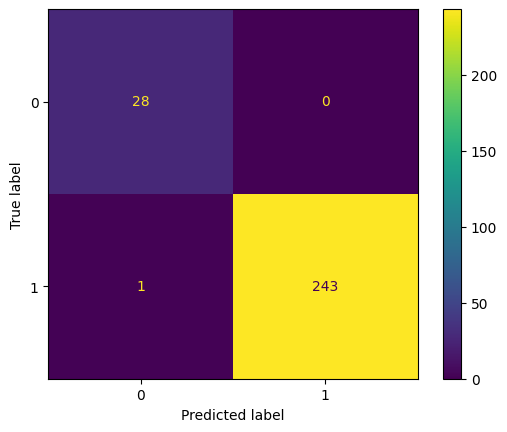

In [36]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)